<a href="https://colab.research.google.com/github/ScienceMoo/DNA_structure_ML/blob/main/Binary_Classification_without_shapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read data

In [ ]:
import scipy.io
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import matplotlib.pyplot as plt
%matplotlib inline
from seaborn import heatmap

from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D
from keras.optimizers import SGD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_sequences.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

sequences = mat['sequences2']
sequences = [word for word_array in sequences for word in word_array[0]]
sequences = np.array(sequences)
num_sample, seq_length = sequences.shape[0], sequences.shape[1]
print("sequences.shape =", sequences.shape)
print("num_sample =", num_sample)
print("seq_length =", seq_length)
print("")
print("sequences =", sequences)

sequences.shape = (158004, 15)
num_sample = 158004
seq_length = 15

sequences = [['A' 'A' 'C' ... 'G' 'G' 'C']
 ['G' 'C' 'G' ... 'G' 'C' 'A']
 ['G' 'T' 'G' ... 'G' 'G' 'C']
 ...
 ['G' 'C' 'A' ... 'G' 'G' 'G']
 ['C' 'T' 'G' ... 'G' 'G' 'G']
 ['G' 'C' 'G' ... 'G' 'G' 'C']]


In [ ]:
file_folder = "/content/drive/MyDrive/Colab Notebooks"
file_name = "CTCF_PWM.mat"
file_path = file_folder + "/" + file_name

mat = scipy.io.loadmat(file_path, chars_as_strings=1, matlab_compatible=1)

freq = mat['pwm_matrix']
freq = np.exp(freq)

freq = freq + 0.001
print("freq.shape =", freq.shape)
freq

freq.shape = (4, 15)


array([[0.056, 0.026, 0.07 , 0.044, 0.002, 0.264, 0.006, 0.002, 0.034,
        0.268, 0.022, 0.082, 0.012, 0.028, 0.128],
       [0.32 , 0.648, 0.044, 0.792, 0.996, 0.668, 0.62 , 1.   , 0.066,
        0.092, 0.346, 0.196, 0.004, 0.068, 0.596],
       [0.568, 0.026, 0.794, 0.064, 0.002, 0.048, 0.004, 0.004, 0.01 ,
        0.566, 0.622, 0.046, 0.978, 0.842, 0.076],
       [0.064, 0.308, 0.1  , 0.108, 0.008, 0.028, 0.378, 0.002, 0.898,
        0.082, 0.018, 0.684, 0.014, 0.07 , 0.208]])

In [ ]:
inds = []
for idx, sequence in enumerate(sequences):
  if 'N' in sequence:
    inds.append(idx)

sequences = np.delete(sequences, inds, axis=0)
print("sequences.shape =", sequences.shape)
y = np.delete(y, inds, axis=0)
num_sample, seq_length = sequences.shape[0], sequences.shape[1]
print("num_sample =", num_sample)
print("seq_length =", seq_length)

sequences.shape = (157999, 15)
num_sample = 157999
seq_length = 15


# Prepare data

In [ ]:
neg = np.array([np.random.choice(['A', 'C', 'G', 'T'], num_sample, p=freq[:,i]/sum(freq[:,i])) 
                for i in range(seq_length)]).transpose()
[''.join(x) for x in neg[1:10,:]]

['GCACCCCCTCGAGAC',
 'GCGACCCCTGGTGGT',
 'CTGCCACCAGGGGGC',
 'CCGCCCCCTTGTGAC',
 'GTAGCCCCCGGTGGC',
 'GTGCCACCTGCCGGC',
 'CTGCCATCTGGCGGA',
 'GCGTCATCTGGTGGC',
 'GCGCCCTCTGATGCC']

In [ ]:
X = np.zeros(list(sequences.shape) + [4])
neg_X = np.zeros(list(neg.shape) + [4])

base_dict = {'A': 0, 'C': 1, 'G': 2, 'T': 3}

#naive one-hot encoding
for row in range(num_sample):
    for col in range(seq_length):
        X[row,col,base_dict[sequences[row,col]]] = 1
        neg_X[row,col,base_dict[neg[row,col]]] = 1

X = np.vstack((X, neg_X))
y = np.concatenate((np.ones(num_sample), np.zeros(num_sample)))

print('Training set shape: {}'.format(X.shape))
print('Training set label shape: {}'.format(y.shape))
print('\nOne-hot encoding looks like:\n {}'.format(X[0,0:10,:]))

Training set shape: (315998, 15, 4)
Training set label shape: (315998,)

One-hot encoding looks like:
 [[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [ ]:
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15)

# Deep Learning

In [ ]:
#here comes the deep learning part

model = Sequential()
model.add(Conv1D(1, 15, padding='same', activation='relu'))
model.add(Conv1D(1, 15, padding='same', activation='relu'))

#sanity check for dimensions
print('Shape of the output of first layer: {}'.format(model.predict_on_batch(X[0:32,:,:]).shape))

Shape of the output of first layer: (32, 15, 1)


In [ ]:
# model.add(MaxPooling1D(pool_length=4))
model.add(Dropout(0))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='binary_crossentropy',
              metrics=['accuracy'])

hist = model.fit(X, y, validation_split=0.3, epochs=12)  # starts training

Epoch 1/12
5876/5876 [==============================] - 15s 3ms/step - loss: 0.5579 - accuracy: 0.7159 - val_loss: 0.5587 - val_accuracy: 0.7226
Epoch 2/12
5876/5876 [==============================] - 15s 3ms/step - loss: 0.5374 - accuracy: 0.7402 - val_loss: 0.5333 - val_accuracy: 0.7422
Epoch 3/12
5876/5876 [==============================] - 14s 2ms/step - loss: 0.5354 - accuracy: 0.7419 - val_loss: 0.5341 - val_accuracy: 0.7415
Epoch 4/12
5876/5876 [==============================] - 14s 2ms/step - loss: 0.5351 - accuracy: 0.7424 - val_loss: 0.5335 - val_accuracy: 0.7416
Epoch 5/12
5876/5876 [==============================] - 15s 3ms/step - loss: 0.5350 - accuracy: 0.7428 - val_loss: 0.5373 - val_accuracy: 0.7398
Epoch 6/12
5876/5876 [==============================] - 15s 3ms/step - loss: 0.5347 - accuracy: 0.7433 - val_loss: 0.5367 - val_accuracy: 0.7382
Epoch 7/12
5876/5876 [==============================] - 15s 3ms/step - loss: 0.5345 - accuracy: 0.7434 - val_loss: 0.5397 - val_ac

In [ ]:
def my_softmax(row):
  if min(row) != 0:
    row = row - min(row)
  return row / sum(row)

Convolution parameter shape: (15, 4)
[[61 18  0 20]
 [25  0 17 57]
 [40  0 39 19]
 [22  0 37 40]
 [19 26 53  0]
 [ 0 42 26 31]
 [ 0 10 36 52]
 [12  0 73 13]
 [40 26 33  0]
 [27 25 46  0]
 [31  0 40 27]
 [26  0 23 50]
 [ 8  0 74 16]
 [92  2  0  5]
 [ 0 33 65  1]]


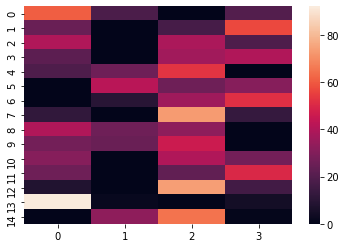

In [ ]:
#have a look at the filter

convlayer = model.layers[0]
weights = convlayer.get_weights()[0].squeeze()
print('Convolution parameter shape: {}'.format(weights.shape))
weights = 1 / weights
weights = np.apply_along_axis(my_softmax, 1, weights)
weights = weights * 100
weights = weights.astype(int)
print(weights)
heatmap(weights)

In [ ]:
# predict highest strength sequence
num2seq = ['A','C','G','T']
weights = softmax(weights, axis=1)
''.join([num2seq[np.argmax(weights[i,:])] for i in range(weights.shape[0])])  

'ATATGCTGAGGTGAG'

In [ ]:
# predict highest strength sequence
num2seq = ['A','C','G','T']

''.join([num2seq[np.argmin(weights[i,:])] for i in range(weights.shape[0])])

'AGCTATATAGTGAAG'

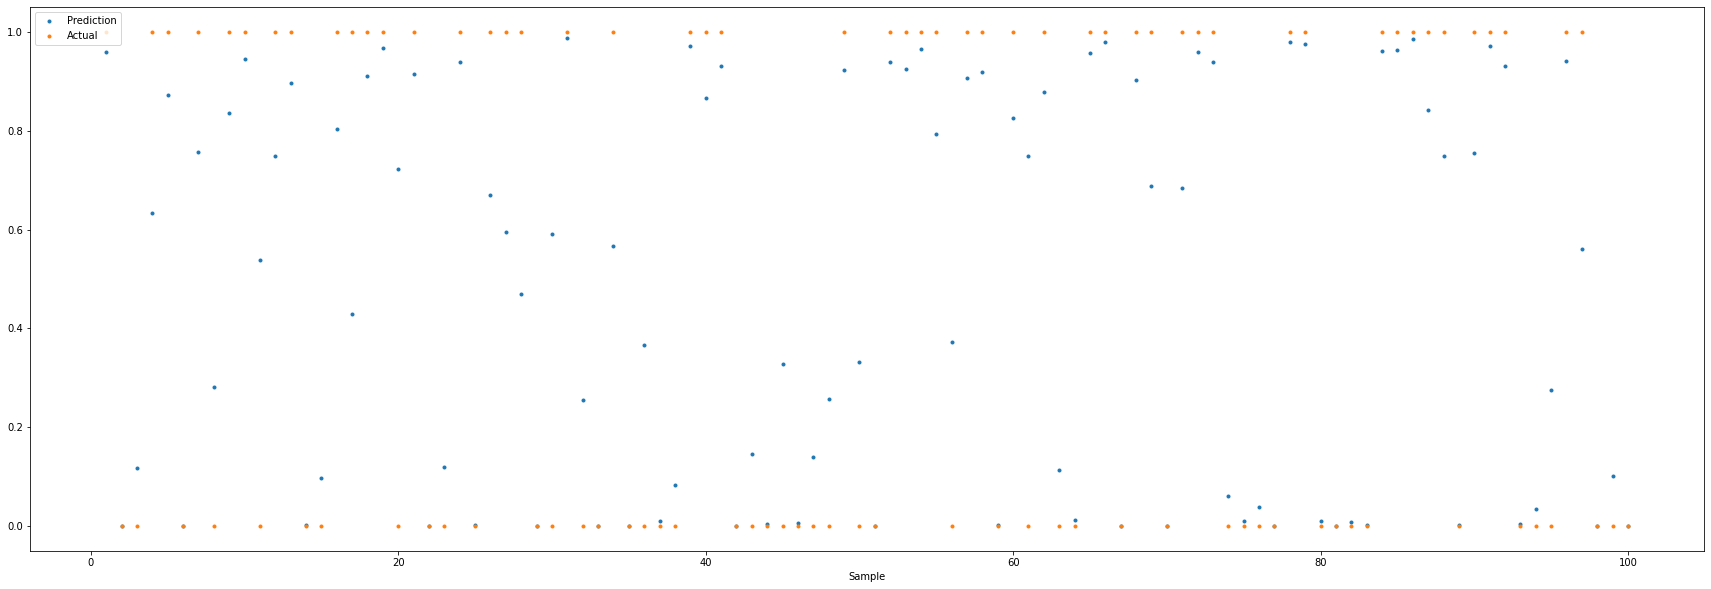

In [ ]:
pred = model.predict(X_test)
# print("pred =", pred[:20])
# print("y_test =", y_test[:20])

fig=plt.figure(figsize=(30, 10))

plt.plot(np.arange(1, 101), pred[:100], '.', label="Prediction")
plt.plot(np.arange(1, 101), y_test[:100], '.', label="Actual")
plt.xlabel('Sample')

plt.legend(loc='upper left')

plt.show()